# 02. Neural Network Classification with PyTorch
Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

## 1. Make classification and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"Print first 5 samples of X: {X[:5]}")
print(f"Print first 5 samples of y: {y[:5]}")

Print first 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Print first 5 samples of y: [1 1 1 1 0]


In [4]:
# Make DaraFrame of cirle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


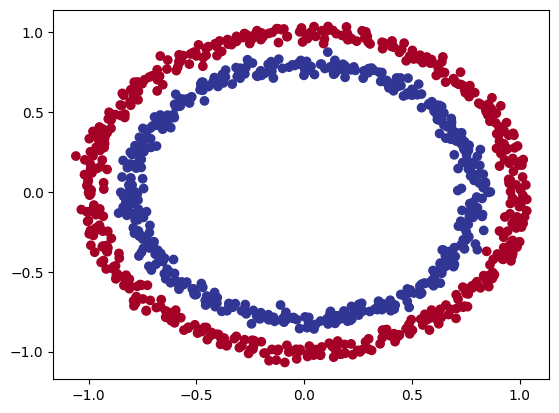

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

**Note**: The data we're working with is often refered to as a toy dataset, a dataset that is small enough to expiriment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and outpur shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes of X sample: {X_sample.shape}, y sample: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes of X sample: (2,), y sample: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
# Turn data into tensors
import torch
torch.__version__

'2.3.1'

In [9]:
X = torch.tensor(X).type(torch.float32)
y = torch.tensor(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X), len(X_train), len(X_test)

(1000, 800, 200)

## Building a model

Let's build a model to classify out blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on a accelerator (TPU, GPU, CPU) if there is one.
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer.
4. Create a training and test loop.

In [12]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

Now we're device agnostic code, let's build a model.

1. Subclass `nn.Module`
2. Create 2 `nn.Linear` layers that are capable of processing 2-dimensional data (our x & y coordinates of the data).
3. Define a forward method which will take in a set of `x` data and pass it through the operations we've defined.
4. Instantiate the model and see what it does to a sample of data.

In [13]:
X_train.shape

torch.Size([800, 2])

In [14]:
# 1. Construct the model that extends the nn.Module class
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Define the layers in the constructor
        self.fc1 = nn.Linear(in_features=2,
                             out_features=4)
        self.fc2 = nn.Linear(in_features=4,
                             out_features=1)
        
        # self.two_linear = nn.Sequential(
        #     nn.Linear(2, 4),
        #     nn.Linear(4, 1)
        # )
    # 3. Implement the forward method
    def forward(self, X):
        return self.fc2(self.fc1(X))
        # return self.two_linear(X)
    
# 4. Instantiate the model
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)

In [15]:
# Let's replicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(2, 4),
    nn.Linear(4, 1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=1, bias=True)
)

In [16]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3062, -0.2757],
                      [-0.0150,  0.4427],
                      [ 0.1479,  0.3493],
                      [-0.4910,  0.3941]])),
             ('0.bias', tensor([ 0.5644, -0.5026,  0.5373,  0.3155])),
             ('1.weight', tensor([[ 0.1469,  0.4300,  0.2599, -0.0314]])),
             ('1.bias', tensor([0.3364]))])

In [17]:
# Make predictions with out model
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(f"Lenght of predictions: {len(untrained_preds)}, shape of predictions: {untrained_preds.shape}")
    print(f"Lenght of test samples: {len(X_test)}, shape of test samples: {X_test.shape}")
    print(f"\nFirst 10 predictions: {untrained_preds[:10]}")
    print(f"\nFirst 10 labels: {y_test[:10]}")

Lenght of predictions: 200, shape of predictions: torch.Size([200, 1])
Lenght of test samples: 200, shape of test samples: torch.Size([200, 2])

First 10 predictions: tensor([[0.4541],
        [0.5534],
        [0.1962],
        [0.5271],
        [0.2004],
        [0.2610],
        [0.5375],
        [0.4691],
        [0.1964],
        [0.5602]])

First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again...this is problem specific.

For example for regression you might want MAE or MSE ( mean absolute error or mean squared error) and Adam optimizer.

For classification, you might want `nn.CrossEntropyLoss` and Adam optimizer.

As a reminder, the loss function is used to calculate how far off our model is from the target and the optimizer is used to update the model's weights. Two of the most common choices for optimization are `SGD` and `Adam`.

* For the loss function we're going to use `torch.nn.BECWithLogitsLoss`.

In [18]:
# Setup the loss function
# loss_function = nn.BCELoss()  # BCELoss = requires to have gone through the sigmoid activation function prior to input to BCELoss
loss_function = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = sigmoid activation function builtin

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [19]:
# Calculate the accuracy - out of 100 example, what percentage did the model get correct
def binary_accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred.round()).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## Training a model

To train out model, we're going to need a training loop.

1. Forward pass
2. Calculate the loss
3. Optimize zero gradients
4. Backward pass (backpropagation)
5. Opmizer step (gradient descent)

### 3.1 Goign from raw logits -> prediction probabilities -> prediction labels

Our model output going to be raw ** logits**.  

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. `torch.sigmoid` for binary for classification or `torch.softmax` for multiclass classification).

Then we can convert our model's prediction probabilities to **predict labels** by either rounding them or taking the `aermax()` of the predicted probabilities.

In [20]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4541],
        [0.5534],
        [0.1962],
        [0.5271],
        [0.2004]])

In [21]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [22]:
# Use the sigmoid activation function to turn logits into probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6116],
        [0.6349],
        [0.5489],
        [0.6288],
        [0.5499]])

For our prediction probability values, we need to perform a range-style rounding on them: 
* `y_preds_probs` >= 0.5, `y=1` (class 1)
* `y_preds_probs` < 0.5, `y=0` (class 0)

In [23]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and test loop

In [25]:
device

'cpu'

In [26]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and avaliation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    loss = loss_function(y_logits, y_train)

    # 4. Backward pass (backpropagation)
    loss.backward()

    # 5. Optimizer Step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        y_test_logits = model_0(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        test_loss = loss_function(y_test_logits,
                                  y_test)
        test_acc = binary_accuracy(y_true=y_test,
                                   y_pred=y_test_pred)

    # Print the metrics
    if epoch % 10 == 0:
        print(f"Epoch {epoch} => Training Loss: {loss:.4f}, Training Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
        

Epoch 0 => Training Loss: 0.7082, Training Accuracy: 50.00%, Test Loss: 0.7156, Test Accuracy: 50.00%
Epoch 10 => Training Loss: 0.7019, Training Accuracy: 50.00%, Test Loss: 0.7088, Test Accuracy: 50.00%
Epoch 20 => Training Loss: 0.6933, Training Accuracy: 50.00%, Test Loss: 0.6956, Test Accuracy: 50.00%
Epoch 30 => Training Loss: 0.7011, Training Accuracy: 50.00%, Test Loss: 0.6975, Test Accuracy: 50.00%
Epoch 40 => Training Loss: 0.7006, Training Accuracy: 50.00%, Test Loss: 0.7005, Test Accuracy: 50.00%
Epoch 50 => Training Loss: 0.6942, Training Accuracy: 46.50%, Test Loss: 0.6932, Test Accuracy: 46.50%
Epoch 60 => Training Loss: 0.7019, Training Accuracy: 50.00%, Test Loss: 0.7042, Test Accuracy: 50.00%
Epoch 70 => Training Loss: 0.6939, Training Accuracy: 42.50%, Test Loss: 0.6990, Test Accuracy: 42.50%
Epoch 80 => Training Loss: 0.7024, Training Accuracy: 50.00%, Test Loss: 0.7055, Test Accuracy: 50.00%
Epoch 90 => Training Loss: 0.7020, Training Accuracy: 50.00%, Test Loss: 0

## 4. Make predictions and evaluate the model

Form the metrics it looks like our model isn't training very well.

Let's make some predictions and evaluate the model and make them visual.

To do so, we're going to import a function called `plot_decision_boundary` which will help us visualize how our model is doing.

In [27]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

# from torch import nn

# def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
#     """
#     Plots decision boundaries of model predicting on X in comparison to y.
#     """

#     # Put everything on to the CPU for plotting (works better with NumPy + Matplotlib)
#     model.to("cpu")
#     X, y = X.to("cpu"), y.to("cpu")

#     # Setup prediction boundaries and grid
#     x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
#     y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
#     xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100),
#                             torch.linspace(y_min, y_max, 100))
    
#     # Make features
#     X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

#     # Make predictions
#     model.eval()
#     with torch.inference_mode():
#         y_logits = model(X_to_pred_on)
    
#     # Test for multi-class or binary and adjust logits to prediction labels
#     if len(torch.unique(y)) > 2:
#         y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)   # multi-class
#     else:
#         y_pred = torch.round(torch.sigmoid(y_logits))           # binary
    
#     # Reshape preds and plot
#     y_pred = y_pred.reshape(xx.shape).detach().numpy()
#     plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
#     plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
#     plt.xlim(xx.min(), xx.max())
#     plt.ylim(yy.min(), yy.max())

In [28]:
import requests
from pathlib import Path

# Download the helper function form Learn Pytorch repo (if it's not already downlaoded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already downloaded")
else:
    print("Downloading helper_functions.py...")
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"

    r = requests.get(url)
    with open("helper_functions.py", "wb") as f:
        f.write(r.content)


helper_functions.py already downloaded


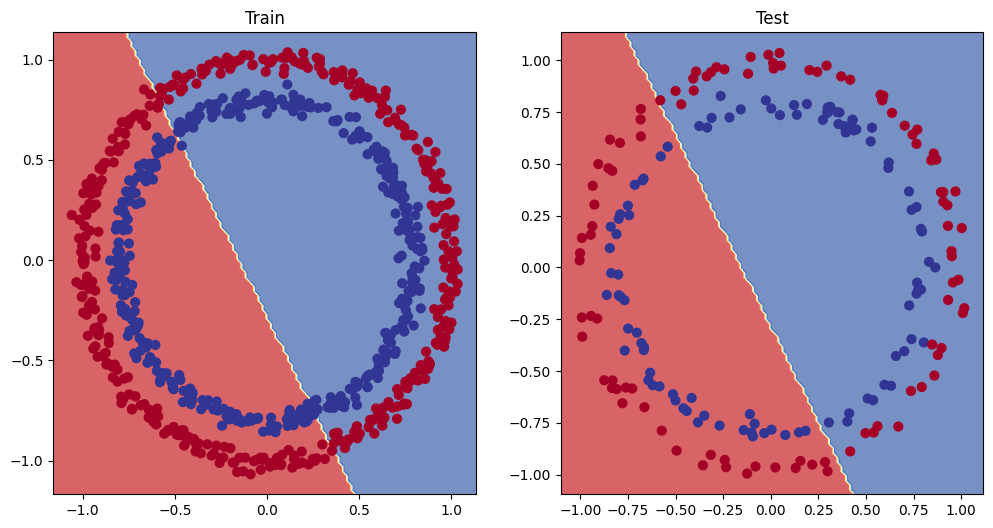

In [29]:
from helper_functions import plot_decision_boundary
# Plot decisions boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_0, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_0, X=X_test, y=y_test)
plt.show()

## 5. Improving a model (from a model perspective)

* add more layers - give the model more changes to learn about pattern in the data.
* increase the number of hidden units - similar to above. Go from 4 to 10 hidden units.
* train for longer - increase the number of epochs (5 to 100).
* change the optimizer - use Adam instead of SGD.
* change the learning rate - increase the learning rate.
* change the activation function - use ReLU instead of sigmoid.

These options are all from our model perspective, because they deal directly with our model, rather than the data or the evaluation of the model.

And because these options are all values we (as machine learning engineers) can change, they're often referred to as **hyperparameters**.

Let's try some of these options and see if we can improve our model:
* Add more layers (2 layers -> 3 layers)
* Increase the number of hidden units (4 units -> 10 units)
* Train for longer (100 epochs -> 1000 epochs)

In [30]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, X):
        return self.fc3(self.fc2(self.fc1(X)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss function

# Create an optimizer

# Wirte a training and evaluation loop